In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("/content/pairs_by_chapters_connectors.csv")

df.shape

(64546, 3)

In [ ]:
df = df.drop_duplicates(subset=["text1", "text2", "label"])
df.shape

(59373, 3)

In [ ]:
df[df["label"] == 1].shape

(30245, 3)

In [ ]:
df[df["label"] == 0].shape

(29128, 3)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df[train_df["label"] == 1].shape

(24238, 3)

In [ ]:
test_df[test_df["label"] == 0].shape

(5868, 3)

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"  # Enable device-side assertions
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import gc
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from peft import get_peft_model, LoraConfig, TaskType

# === GPU Setup ===
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Using GPU: {gpu_name} ({gpu_mem:.2f} GB)")
    torch.cuda.empty_cache()
    gc.collect()
    device = 'cuda'
else:
    device = 'cpu'

# === Load Model ===
model_name = "NLPC-UOM/SinBERT-large"
base_model = SentenceTransformer(model_name, device=device)
print("Model loaded")

# === Attach LoRA ===
config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,  # Reduced from 16
    lora_alpha=16,  # Reduced from 32
    lora_dropout=0.1,
    target_modules=["query", "value"],
    bias="none",
    inference_mode=False
)

first_module = base_model._first_module()
first_module.auto_model = get_peft_model(first_module.auto_model, config)
first_module.auto_model.to(device)
print("LoRA attached")

# === CRITICAL: Deep data validation ===
print("\n=== Deep Data Validation ===")

# Check original data
print(f"Original size: {len(train_df)}")
print(f"Columns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head())

# Check for problematic characters
def check_text_issues(df, col_name):
    issues = []
    for idx, text in enumerate(df[col_name]):
        if pd.isna(text):
            issues.append(f"Row {idx}: NaN")
        elif not isinstance(text, str):
            issues.append(f"Row {idx}: Not string - type is {type(text)}")
        elif len(str(text).strip()) == 0:
            issues.append(f"Row {idx}: Empty string")
        elif len(str(text)) > 512:  # Check very long texts
            issues.append(f"Row {idx}: Very long text ({len(text)} chars)")
    return issues

print("\nChecking text1:")
issues_text1 = check_text_issues(train_df, 'text1')
if issues_text1:
    print(f"Found {len(issues_text1)} issues (showing first 5):")
    print(issues_text1[:5])
else:
    print("No issues found")

print("\nChecking text2:")
issues_text2 = check_text_issues(train_df, 'text2')
if issues_text2:
    print(f"Found {len(issues_text2)} issues (showing first 5):")
    print(issues_text2[:5])
else:
    print("No issues found")

# Check labels specifically
print("\nLabel analysis:")
print(f"Data type: {train_df['label'].dtype}")
print(f"Unique values: {sorted(train_df['label'].unique())}")
print(f"NaN count: {train_df['label'].isna().sum()}")
print(f"Min: {train_df['label'].min()}, Max: {train_df['label'].max()}")

# CRITICAL: Check for labels that aren't exactly 0.0 or 1.0
unusual_labels = train_df[~train_df['label'].isin([0.0, 1.0])]
if len(unusual_labels) > 0:
    print(f"\nWARNING: Found {len(unusual_labels)} rows with unusual labels:")
    print(unusual_labels[['text1', 'text2', 'label']].head())

# === Aggressive data cleaning ===
print("\n=== Aggressive Data Cleaning ===")
train_df_clean = train_df.copy()

# Remove NaN
initial_size = len(train_df_clean)
train_df_clean = train_df_clean.dropna(subset=['text1', 'text2', 'label'])
print(f"After NaN removal: {len(train_df_clean)} (removed {initial_size - len(train_df_clean)})")

# Convert labels to float and keep only 0.0 or 1.0
train_df_clean['label'] = train_df_clean['label'].astype(float)
train_df_clean = train_df_clean[train_df_clean['label'].isin([0.0, 1.0])]
print(f"After label filtering: {len(train_df_clean)}")

# Ensure strings
train_df_clean['text1'] = train_df_clean['text1'].astype(str)
train_df_clean['text2'] = train_df_clean['text2'].astype(str)

# Remove empty or very short texts
train_df_clean = train_df_clean[train_df_clean['text1'].str.strip().str.len() >= 3]
train_df_clean = train_df_clean[train_df_clean['text2'].str.strip().str.len() >= 3]
print(f"After text length filtering: {len(train_df_clean)}")

# Truncate very long texts (important for GPU memory)
max_length = 256
train_df_clean['text1'] = train_df_clean['text1'].str[:max_length]
train_df_clean['text2'] = train_df_clean['text2'].str[:max_length]
print(f"Texts truncated to max {max_length} characters")

# Reset index
train_df_clean = train_df_clean.reset_index(drop=True)

print(f"\nFinal dataset size: {len(train_df_clean)}")
print(f"Label distribution:\n{train_df_clean['label'].value_counts()}")

# === Split data ===
val_size = int(0.1 * len(train_df_clean))
val_df = train_df_clean.tail(val_size).reset_index(drop=True)
train_df_subset = train_df_clean.head(len(train_df_clean) - val_size).reset_index(drop=True)

print(f"\nTraining samples: {len(train_df_subset)}")
print(f"Validation samples: {len(val_df)}")

# === Test model with a small sample BEFORE full training ===
print("\n=== Testing model with sample data ===")
try:
    test_texts = [
        train_df_subset.iloc[0]['text1'],
        train_df_subset.iloc[0]['text2']
    ]
    print(f"Test text 1: {test_texts[0][:50]}...")
    print(f"Test text 2: {test_texts[1][:50]}...")

    embeddings = base_model.encode(test_texts, convert_to_tensor=True)
    print(f"Encoding successful! Embedding shape: {embeddings.shape}")
    print(f"Embedding range: [{embeddings.min():.4f}, {embeddings.max():.4f}]")

    # Check for NaN or Inf in embeddings
    if torch.isnan(embeddings).any():
        print("ERROR: NaN detected in embeddings!")
    if torch.isinf(embeddings).any():
        print("ERROR: Inf detected in embeddings!")

except Exception as e:
    print(f"Encoding test failed: {e}")
    import traceback
    traceback.print_exc()

# === Create evaluator ===
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_df["text1"].tolist(),
    sentences2=val_df["text2"].tolist(),
    scores=val_df["label"].tolist(),
    name="validation",
    batch_size=2  # Small batch size for evaluation
)

# === Prepare DataLoader with additional validation ===
print("\n=== Creating DataLoader ===")
train_examples = []
for idx, row in train_df_subset.iterrows():
    try:
        example = InputExample(
            texts=[str(row["text1"]), str(row["text2"])],
            label=float(row["label"])
        )
        train_examples.append(example)
    except Exception as e:
        print(f"Error creating InputExample at index {idx}: {e}")

print(f"Created {len(train_examples)} training examples")

batch_size = 2
train_dataloader = DataLoader(
    train_examples,
    shuffle=True,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=False
)

# === Create loss ===
train_loss = losses.ContrastiveLoss(base_model, margin=0.5)

# === Train with more conservative settings ===
print("\n=== Starting Training ===")
print(f"Batch size: {batch_size}")
print(f"Total batches: {len(train_dataloader)}")
print(f"Epochs: 1")  # Start with just 1 epoch

try:
    base_model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=2,  # Just 1 epoch for testing
        warmup_steps=10,  # Reduced warmup
        output_path='./sinbert_finetuned',
        evaluator=evaluator,
        evaluation_steps=500,  # Less frequent evaluation
        save_best_model=True,
        show_progress_bar=True,
        use_amp=False,
        checkpoint_save_steps=1000,
        checkpoint_save_total_limit=1
    )
    print("Training completed successfully!")

except RuntimeError as e:
    print(f"Runtime Error: {e}")
    import traceback
    traceback.print_exc()

except Exception as e:
    print(f"Training failed: {e}")
    import traceback
    traceback.print_exc()

GPU Available: True
✅ Using GPU: Tesla T4 (15.83 GB)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

✅ Model loaded
✅ LoRA attached

=== Deep Data Validation ===
Original size: 47498
Columns: ['text1', 'text2', 'label']

First few rows:
                                                   text1  \
14808                               ඉල්ලා අස්විය හැකි බව   
2934                                                 41ඌ   
16151  (ඇ) යම්කිසි තැනැත්තෙක් සිහිවිකල තැනැත්තකු ලෙස ...   
33604  (ආ) මේ ව්‍යවස්ථාව බලාත්මක වන\nපාර්ලිමේන්තුවේ ම...   
2821                                 සභාවේ බලතල හා කාර්ය   

                                                   text2  label  
14808  අපහාස කිරීමේ හෝ අගෞරව කිරීමේ හෝ වරදකට වරදකරු\n...      1  
2934                                          හැක්කේ ය;]      1  
16151  (එ) (i) යම්කිසි තැනැත්තකු දණ්ඩ නීති සංග්‍රහයේ ...      1  
33604                              184[(11) කිලිනොච්චිය]      0  
2821   හෝ ඊළඟට එළඹෙන වර්ෂයේ ඊට අනුරූප වන දිනය යන\nමෙය...      1  

Checking text1:
Found 293 issues (showing first 5):
['Row 71: Very long text (543 chars)', 'Row 281: Very 

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: niduni-22 (niduni-22-university-of-moratuwa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Validation Pearson Cosine,Validation Spearman Cosine
500,0.035800,No log,0.138751,0.118320
1000,0.034200,No log,0.175121,0.147418
1500,0.030900,No log,0.223363,0.192495
2000,0.031000,No log,0.267823,0.238152
2500,0.028200,No log,0.301981,0.276968
3000,0.028000,No log,0.336245,0.315755
3500,0.027600,No log,0.373370,0.358130
4000,0.026500,No log,0.402383,0.391580
4500,0.025600,No log,0.434181,0.427561
5000,0.024200,No log,0.455102,0.450522


✅ Training completed successfully!


In [ ]:
from huggingface_hub import HfApi

# You'll need to login first
!huggingface-cli login

try:
    # Save LoRA adapters
    first_module = base_model._first_module()
    peft_model = first_module.auto_model
    peft_model.push_to_hub(
        "ndk1973/sinbert-legal-lora",
        use_auth_token=True
    )
    print("Model uploaded to Hugging Face!")
except Exception as e:
    print(f"Error: {e}")

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `hf_write` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential

In [ ]:
!pip install -U peft

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"  # Enable device-side assertions
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from peft import LoraConfig, get_peft_model, TaskType
from sentence_transformers import SentenceTransformer, util # Import util
import torch
import gc
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
import pandas as pd
import numpy as np

# === GPU Setup ===
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"Using GPU: {gpu_name} ({gpu_mem:.2f} GB)")
    torch.cuda.empty_cache()
    gc.collect()
    device = 'cuda'
else:
    device = 'cpu'


# Load the base model first
model_name = "NLPC-UOM/SinBERT-large"
base_model = SentenceTransformer(model_name, device=device) # Load model directly on the right device

# Define the model ID and filename
lora_model_id = "ndk1973/sinbert-legal-lora"
adapter_filename = "adapter_model.safetensors"

try:
    # Download the safetensors file
    adapter_path = hf_hub_download(repo_id=lora_model_id, filename=adapter_filename)
    print(f"Downloaded PEFT adapter to: {adapter_path}")

    # Load the state dictionary using safetensors
    peft_state_dict = load_file(adapter_path)
    print("Loaded PEFT state dictionary using safetensors.")


    # Access the underlying Hugging Face model from SentenceTransformer
    underlying_model = base_model._first_module().auto_model

    # Attach LoRA config to the underlying model
    # Use the same config as during training
    config = LoraConfig(
        task_type=TaskType.FEATURE_EXTRACTION,
        r=8,  # Reduced from 16
        lora_alpha=16,  # Reduced from 32
        lora_dropout=0.1,
        target_modules=["query", "value"],
        bias="none",
        inference_mode=False
    )

    peft_model = get_peft_model(underlying_model, config)

    # --- Debugging: Print shapes ---
    print("\n--- Debugging Shapes ---")
    model_state_dict = peft_model.state_dict()
    for key in peft_state_dict.keys():
        # Adjust key name to match the structure expected by peft_model
        # Remove the 'base_model_model.model.roberta.' prefix
        adjusted_key = key.replace('base_model_model.model.roberta.', '')
        if adjusted_key in model_state_dict:
            print(f"Loaded Key: {key} -> Model Key: {adjusted_key}")
            print(f"  Loaded shape: {peft_state_dict[key].shape}")
            print(f"  Model shape:  {model_state_dict[adjusted_key].shape}")
            if peft_state_dict[key].shape != model_state_dict[adjusted_key].shape:
                print("  Shape mismatch!")
        else:
            print(f"Loaded Key: {key} not found in model state dictionary (adjusted key: {adjusted_key})!")
    print("------------------------\n")
    # --- End Debugging ---

    # Load the state dictionary into the PEFT model
    # Create a new state dictionary with adjusted keys
    adjusted_peft_state_dict = {
        key.replace('base_model_model.model.roberta.', ''): value
        for key, value in peft_state_dict.items()
    }

    # Filter out keys that are not in the model's state_dict
    filtered_state_dict = {
        k: v for k, v in adjusted_peft_state_dict.items() if k in peft_model.state_dict()
    }


    # Load the state dictionary into the PEFT model, setting strict to False to ignore non-matching keys if any remain
    load_result = peft_model.load_state_dict(filtered_state_dict, strict=False)
    print(f"Load result: {load_result}")

    # Replace the base model's auto_model with the loaded PEFT model
    # Need to put the peft_model back into the SentenceTransformer's structure
    base_model._first_module().auto_model = peft_model

    print("Fine-tuned model loaded and ready for evaluation.")

    # --- Evaluation Code ---
    # CRITICAL: Add aggressive data cleaning here before evaluation
    print("\n=== Aggressive Data Cleaning for Evaluation Data ===")
    test_df_clean = test_df.copy()

    # Remove NaN
    initial_size = len(test_df_clean)
    test_df_clean = test_df_clean.dropna(subset=['text1', 'text2', 'label'])
    print(f"After NaN removal: {len(test_df_clean)} (removed {initial_size - len(test_df_clean)})")

    # Convert labels to float and keep only 0.0 or 1.0
    test_df_clean['label'] = test_df_clean['label'].astype(float)
    test_df_clean = test_df_clean[test_df_clean['label'].isin([0.0, 1.0])]
    print(f"After label filtering: {len(test_df_clean)}")

    # Ensure strings
    test_df_clean['text1'] = test_df_clean['text1'].astype(str)
    test_df_clean['text2'] = test_df_clean['text2'].astype(str)

    # Remove empty or very short texts
    test_df_clean = test_df_clean[test_df_clean['text1'].str.strip().str.len() >= 3]
    test_df_clean = test_df_clean[test_df_clean['text2'].str.strip().str.len() >= 3]
    print(f"After text length filtering: {len(test_df_clean)}")

    # Truncate very long texts (important for GPU memory)
    max_length = 256 # Use the same max length as during training
    test_df_clean['text1'] = test_df_clean['text1'].str[:max_length]
    test_df_clean['text2'] = test_df_clean['text2'].str[:max_length]
    print(f"Texts truncated to max {max_length} characters")

    # Reset index
    test_df_clean = test_df_clean.reset_index(drop=True)

    print(f"\nFinal evaluation dataset size: {len(test_df_clean)}")
    print(f"Label distribution:\n{test_df_clean['label'].value_counts()}")

    # --- Debugging: Inspect data before encoding ---
    print("\n=== Inspecting Data Before Encoding ===")
    sample_size = 5 # Inspect a few samples
    print(f"First {sample_size} rows of cleaned test_df:")
    print(test_df_clean.head(sample_size))

    # Check data types
    print("\nData types of text columns:")
    print(test_df_clean[['text1', 'text2']].dtypes)

    # Check for empty strings after cleaning
    print(f"\nEmpty strings in text1: {test_df_clean['text1'].str.strip().eq('').sum()}")
    print(f"Empty strings in text2: {test_df_clean['text2'].str.strip().eq('').sum()}")

    # Try encoding a very small subset
    print("\nAttempting to encode a small subset:")
    try:
        small_subset_text1 = test_df_clean['text1'].tolist()[:10]
        small_subset_text2 = test_df_clean['text2'].tolist()[:10]
        print(f"Sample text1 subset: {small_subset_text1}")
        print(f"Sample text2 subset: {small_subset_text2}")

        small_emb1 = base_model.encode(small_subset_text1, convert_to_tensor=True, show_progress_bar=False)
        small_emb2 = base_model.encode(small_subset_text2, convert_to_tensor=True, show_progress_bar=False)
        print("✅ Encoding of small subset successful!")
        print(f"Shape of small_emb1: {small_emb1.shape}")
        print(f"Shape of small_emb2: {small_emb2.shape}")

    except Exception as e:
        print(f"Encoding of small subset failed: {e}")
        import traceback
        traceback.print_exc()
except Exception as e:
    print(f"Outer block failed: {e}")
    import traceback
    traceback.print_exc()
print("--------------------------------------\n")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

ImportError: cannot import name 'PreTrainedModel' from 'transformers' (/usr/local/lib/python3.12/dist-packages/transformers/__init__.py)

In [ ]:
!pip install torch==2.2.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html
!pip install peft==0.10.0 transformers==4.38.2

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 820.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99

In [ ]:
from transformers import AutoModel, AutoTokenizer

# Specify the model name from the Hugging Face Hub
model_name = "bert-base-uncased"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Tokenizer '{model_name}' loaded successfully.")

# Load the model
model = AutoModel.from_pretrained(model_name)
print(f"Model '{model_name}' loaded successfully.")

# You can now use the tokenizer and model
# For example, to tokenize some text:
# text = "Hello, world!"
# inputs = tokenizer(text, return_tensors="pt")
# print("Tokenized inputs:", inputs)

# To get model outputs:
# outputs = model(**inputs)
# print("Model outputs:", outputs)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve # Import necessary metrics
import numpy as np # Import numpy to use pi and cos

print("\n🔹 Encoding text pairs with fine-tuned LoRA model...")

emb1 = base_model.encode(
    test_df_clean["text1"].tolist(),
    batch_size=16,
    convert_to_tensor=True,
    show_progress_bar=True,
    device=device
)

emb2 = base_model.encode(
    test_df_clean["text2"].tolist(),
    batch_size=16,
    convert_to_tensor=True,
    show_progress_bar=True,
    device=device
)

print("Encoding complete.")


# === Cosine similarity ===
cos_sim = util.cos_sim(emb1, emb2).diagonal()
cos_sim = cos_sim.cpu().numpy()

# === Labels and predictions ===
labels = test_df_clean["label"].astype(float).values
# Use cosine similarity as the probability score for ROC-AUC
probs = cos_sim
# Make binary predictions based on a threshold of cos(pi/12)
threshold = np.cos(np.pi/12)
preds = (probs > threshold).astype(int)

print(f"\nUsing threshold: {threshold:.4f}")

# === Metrics ===
roc_auc = roc_auc_score(labels, probs)
acc = accuracy_score(labels, preds)

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {acc*100:.2f}%")

# === Plot ROC Curve ===
fpr, tpr, _ = roc_curve(labels, probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fine-tuned LoRA Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


🔹 Encoding text pairs with fine-tuned LoRA model...


NameError: name 'base_model' is not defined

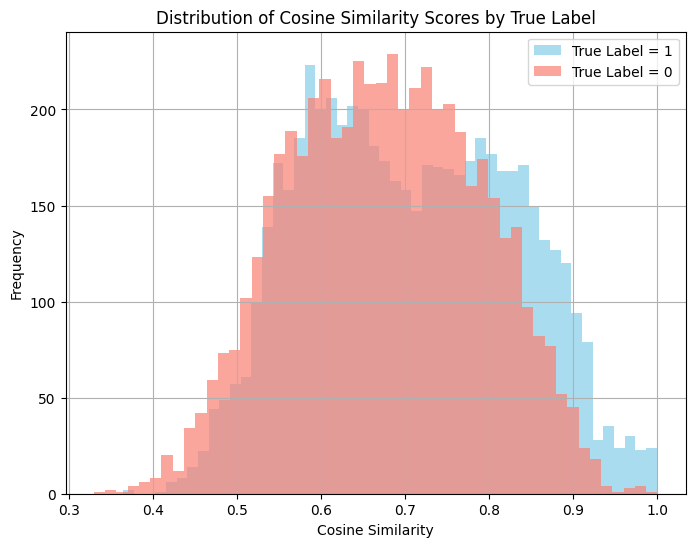

In [ ]:
# === Plotting Actual Labels vs. Predictions ===
plt.figure(figsize=(8, 6))

# Plot distribution of cosine similarities for positive labels
plt.hist(cos_sim[labels == 1], bins=50, alpha=0.7, label='True Label = 1', color='skyblue')

# Plot distribution of cosine similarities for negative labels
plt.hist(cos_sim[labels == 0], bins=50, alpha=0.7, label='True Label = 0', color='salmon')

plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Cosine Similarity Scores by True Label")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("\n--- Comparing Original and Fine-tuned Model Performance ---")

# --- Load Original Model ---
print("\n🔹 Loading original SinBERT-large model...")
# Load the base model again, without LoRA
original_model = SentenceTransformer(model_name, device=device)
print("Original model loaded.")

# --- Evaluate Original Model ---
print("\n🔹 Encoding text pairs with original model...")
original_emb1 = original_model.encode(
    test_df_clean["text1"].tolist(),
    batch_size=16,
    convert_to_tensor=True,
    show_progress_bar=True,
    device=device
)

original_emb2 = original_model.encode(
    test_df_clean["text2"].tolist(),
    batch_size=16,
    convert_to_tensor=True,
    show_progress_bar=True,
    device=device
)

print("Encoding complete for original model.")

# === Cosine similarity for original model ===
original_cos_sim = util.cos_sim(original_emb1, original_emb2).diagonal()
original_cos_sim = original_cos_sim.cpu().numpy()

# === Labels and predictions for original model ===
# Use the same labels and threshold as before
original_labels = test_df_clean["label"].astype(float).values
original_probs = original_cos_sim
original_preds = (original_probs > threshold).astype(int)

print(f"\nUsing threshold for original model: {threshold:.4f}")

# === Metrics for original model ===
original_roc_auc = roc_auc_score(original_labels, original_probs)
original_acc = accuracy_score(original_labels, original_preds)

print(f"\nOriginal Model Metrics:")
print(f"  ROC-AUC: {original_roc_auc:.4f}")
print(f"  Accuracy: {original_acc*100:.2f}%")

# --- Comparison ---
print("\n--- Performance Comparison ---")
print(f"Metric        | Original Model | Fine-tuned LoRA Model")
print(f"--------------|----------------|----------------------")
print(f"ROC-AUC       | {original_roc_auc:<14.4f} | {roc_auc:<20.4f}") # roc_auc is from the previous evaluation
print(f"Accuracy (%)  | {original_acc*100:<14.2f} | {acc*100:<20.2f}") # acc is from the previous evaluation

# === Plot Comparison of Cosine Similarity Distributions ===
plt.figure(figsize=(10, 6))

# Plot distribution for original model
plt.hist(original_cos_sim[original_labels == 1], bins=50, alpha=0.5, label='Original: True Label = 1', color='teal')
plt.hist(original_cos_sim[original_labels == 0], bins=50, alpha=0.5, label='Original: True Label = 0', color='purple')

# Plot distribution for fine-tuned model
plt.hist(cos_sim[labels == 1], bins=50, alpha=0.7, label='Fine-tuned: True Label = 1', color='skyblue', hatch='/', edgecolor='white')
plt.hist(cos_sim[labels == 0], bins=50, alpha=0.7, label='Fine-tuned: True Label = 0', color='salmon', hatch='\\', edgecolor='white')


plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Cosine Similarity Scores by True Label (Original vs. Fine-tuned)")
plt.legend()
plt.grid(True)
plt.show()

# === Plot Comparison of ROC Curves ===
fpr_original, tpr_original, _ = roc_curve(original_labels, original_probs)
fpr_finetuned, tpr_finetuned, _ = roc_curve(labels, probs) # labels and probs are from the previous evaluation

plt.figure(figsize=(6, 5))
plt.plot(fpr_original, tpr_original, color='gray', linestyle='--', label=f"Original (AUC = {original_roc_auc:.4f})")
plt.plot(fpr_finetuned, tpr_finetuned, color='blue', label=f"Fine-tuned (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.5000)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Original vs. Fine-tuned)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()